You should first run the Installing Libraries section before running this cell

In [0]:
import os
import torch
from torch import nn, optim
from torch.utils import data
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import PIL
import json
from collections import OrderedDict
from progressbar import progressbar

%matplotlib inline

# Sync with Google Drive

Mounting the Google Drive data on the Jupyter Colab Notebook.

In [3]:
from google.colab import drive

drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
os.chdir('gdrive/My Drive/Udacity/FinalChallenge')

# Installing Libraries

In [5]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install --upgrade torch torchvision
import torch

    100% |████████████████████████████████| 591.8MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6107a000 @  0x7f75e4e6c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 21.6MB/s 
    100% |████████████████████████████████| 2.0MB 4.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [6]:
!pip install --upgrade pillow

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (5.3.0)


In [3]:
!pip install tqdm

In [7]:
!pip install progressbar2

In [8]:
torch.__version__

'1.0.0'

# Load Data

The data is split into two groups: *training* and *validation*. On the training set will be applied transformations such as random scaling, cropping and flipping. The input data should be sized 224x224 pixels, such as required to the pretrained network. The validation set is used to check the model's performance on data previously unseen. The data will be resized and then cropped to the regular size.

The pretrained networks available on the torchvision model zoo were trained on `ImageNet` dataset, where each color channel was normalized separately. 

For the mean: `[0.485, 0.456, 0.406]`.

For the standard deviations: `[0.229, 0.224, 0.225]`.

This values will shift each color channel to be centered at 0 and range from -1 to 1. 

In [0]:
base_path = 'data/flower_data/'
batch_size = 64

In [0]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize(248),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'),
                                     transform=train_transforms)

valid_dataset = datasets.ImageFolder(os.path.join(base_path, 'valid'),
                                     transform=valid_transforms)

# DataLoader
train_loader = data.DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=8)

valid_loader = data.DataLoader(valid_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=8)

In [12]:
number_of_data = batch_size * len(train_loader)

print(f'There are a total of {number_of_data} pictures on the dataset.')

There are a total of 6592 pictures on the dataset.


## Label Mapping

Dictionary mapping the labels to the name of the flowers.

In [0]:
with open('data/cat_to_name.json') as f:
  cat_to_name = json.load(f)
  
name_to_cat = {}
for k, v in cat_to_name.items():
  name_to_cat[v] = k

# Model

The chosen model will be the ResNet152 pre-trained with `ImageNet` dataset.

The classifier part will be changed to, instead of classifying `ImageNet` labels, will be fine tuned to classify the types of flowers of this project.

Regular classifier block:
```python
(fc): Linear(in_features=2048, out_features=1000, bias=True)
  ```

In [0]:
model = models.resnet152(pretrained=True)

print(model)

In [0]:
for param in model.parameters():
  param.requires_grad = False
  
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('output', nn.Linear(512, 102))
]))


model.fc = fc

## Training

Define hyperparameters:

In [0]:
epochs = 50
lr = 0.001

In [0]:
optimizer = optim.Adagrad(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  model.cuda()

In [0]:
valid_loss_min = np.Inf # Checking the minimum loss to save the current best model
version = 1

training_losses = []
valid_losses = []
epochs_versions = []

for e in range(1, epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  
  model.train()
  
  for x, y in progressbar(train_loader):
    # Moving data to GPU
    if train_on_gpu:
      x, y = x.cuda(), y.cuda()
    
    # Set the gradients to zero
    optimizer.zero_grad()
    
    # Forward Pass
    output = model(x)
    
    # Loss
    loss = criterion(output, y)
    
    # Backward Pass
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * x.size(0)
    
  # After each epoch append the training loss to the array
  train_loss = train_loss / len(train_loader.dataset)
  training_losses.append(train_loss)
  
  # Change to evaluation mode
  model.eval()
  val_acc = 0
  
  for x, y in valid_loader:
    if train_on_gpu:
      x, y = x.cuda(), y.cuda()
    
    # Forward pass
    output = model(x)
    
    # Loss
    loss = criterion(output, y)
    
    # Check loss
    valid_loss += loss.item() * x.size(0)
    
    # Check accuracy
    _, top_class = output.topk(1, dim=1)
    equals = top_class == y.view(*top_class.shape)
    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
    
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tValidation Accuracy: {:.2f}%'.format(e, train_loss, valid_loss, 100*val_acc/len(valid_loader)))
  if valid_loss < valid_loss_min:
    print('\tVersion ' + str(version) + ', validation loss decreased: {} --> {}'.format(
        valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_100_version_' + str(version) + '.pt')
    valid_loss_min = valid_loss
    version += 1
    epochs_versions.append(e)
    
  # Saving loss per epoch
  valid_loss = valid_loss / len(valid_loader.dataset)
  valid_losses.append(valid_loss)

100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 1 	Training Loss: 0.299755 	Validation Loss: 251.361451	Validation Accuracy: 91.92%
	Version 1, validation loss decreased: inf --> 251.36145091056824


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 2 	Training Loss: 0.292733 	Validation Loss: 241.266425	Validation Accuracy: 91.69%
	Version 2, validation loss decreased: 251.36145091056824 --> 241.2664247751236


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 3 	Training Loss: 0.290953 	Validation Loss: 246.684904	Validation Accuracy: 92.05%


100% (103 of 103) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Epoch: 4 	Training Loss: 0.291283 	Validation Loss: 251.605958	Validation Accuracy: 91.61%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 5 	Training Loss: 0.290072 	Validation Loss: 246.676927	Validation Accuracy: 91.54%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 6 	Training Loss: 0.296358 	Validation Loss: 249.914078	Validation Accuracy: 91.26%


100% (103 of 103) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Epoch: 7 	Training Loss: 0.289990 	Validation Loss: 241.188464	Validation Accuracy: 91.75%
	Version 3, validation loss decreased: 241.2664247751236 --> 241.18846410512924


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 8 	Training Loss: 0.282847 	Validation Loss: 241.270343	Validation Accuracy: 91.99%


100% (103 of 103) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Epoch: 9 	Training Loss: 0.285811 	Validation Loss: 251.958839	Validation Accuracy: 91.49%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 10 	Training Loss: 0.290307 	Validation Loss: 243.432337	Validation Accuracy: 91.40%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 11 	Training Loss: 0.283868 	Validation Loss: 244.327669	Validation Accuracy: 92.41%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 12 	Training Loss: 0.273036 	Validation Loss: 243.653392	Validation Accuracy: 91.88%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 13 	Training Loss: 0.287438 	Validation Loss: 239.765863	Validation Accuracy: 91.97%
	Version 4, validation loss decreased: 241.18846410512924 --> 239.76586323976517


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 14 	Training Loss: 0.279112 	Validation Loss: 249.485317	Validation Accuracy: 91.21%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 15 	Training Loss: 0.287081 	Validation Loss: 238.519675	Validation Accuracy: 92.17%
	Version 5, validation loss decreased: 239.76586323976517 --> 238.5196751356125


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 16 	Training Loss: 0.274169 	Validation Loss: 242.312336	Validation Accuracy: 92.50%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 17 	Training Loss: 0.285603 	Validation Loss: 241.065796	Validation Accuracy: 92.26%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 18 	Training Loss: 0.278534 	Validation Loss: 246.611820	Validation Accuracy: 91.85%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 19 	Training Loss: 0.285715 	Validation Loss: 239.581634	Validation Accuracy: 92.02%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 20 	Training Loss: 0.286644 	Validation Loss: 245.103015	Validation Accuracy: 92.14%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 21 	Training Loss: 0.275290 	Validation Loss: 244.449036	Validation Accuracy: 91.78%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 22 	Training Loss: 0.276844 	Validation Loss: 236.859923	Validation Accuracy: 92.84%
	Version 6, validation loss decreased: 238.5196751356125 --> 236.859923183918


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 23 	Training Loss: 0.270322 	Validation Loss: 247.139785	Validation Accuracy: 91.61%


 22% (23 of 103) |#####                  | Elapsed Time: 0:00:27 ETA:   0:01:36

In [0]:
train_loss = np.concatenate([train_loss, train_loss_2])
valid_loss = np.concatenate([valid_loss, valid_loss_2])

Text(0.5,1,'Training Loss 92.84%')

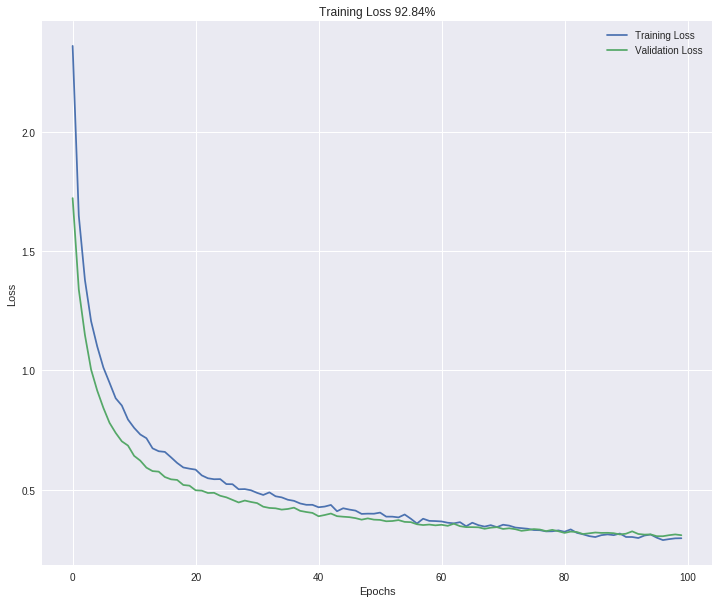

In [26]:
plt.figure(figsize=(12.0, 10.0))

plt.plot(train_loss)
plt.plot(valid_loss)

plt.legend(['Training Loss', 'Validation Loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training Loss 92.84%')

# Testing the trained model

In [0]:
model = models.load_model('')